# Multi-output Regression Data EDA

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from notebook_utils import run_xgb_model, scores_barplot, plot_feature_imps, run_lin_reg_model, present_model_results

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

sns.set_theme(style="whitegrid")

## Load & prep Data

In [2]:
# Load dataset from csv
data = pd.read_csv("data\\dataset-merged.csv")
data.drop(['sheepid'], axis=1, inplace=True)
print(data.head().transpose())

# Split training samples from labels
input_cols = ['breed', 'sex', 'slaughgr', 'slweight(g)']
X = data[input_cols]
y = data.drop(input_cols, axis=1)

# Split train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=96)
print('Train set shape:', X_train.shape, y_train.shape)
print('Test set shape:', X_test.shape, y_test.shape)


                 0      1      2      3     4
breed            1      1      1      1     1
sex              1      1      1      1     0
slaughgr         1      1      1      1     1
slweight(g)  12399  12500  12300  12399  9500
woolfr         150    130    140    120   150
blood          575    575    600    625   475
feet           450    475    475    450   375
pelt          1250   1245   1200   1225  1000
fullGI        1400   1500   1300   1375  1375
mesent         100     75    100    125    70
epipl          150     75    125    250    50
liver          275    300    275    300   225
spleen          30     50     50     50    25
pluck          425    525    400    400   375
head           635    650    625    650   525
warmcarc      6850   6800   6875   6850  4825
kidney          32     32     32     34    26
KKCF           122     78    118    154    74
tail            32     32     44     32    32
coldcarc      6612   6542   6776   6642  4710
mw%             25     25     25  

## Summary
Σύνοψη του συνόλου δεδομένων.

In [3]:
print("Data shape:", data.shape, '\n')
data.info()
print("\nEmpty values/column sum:\n", data.isna().sum())
print('\nDescribe:')
data.describe()

Data shape: (119, 30) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   breed        119 non-null    int64
 1   sex          119 non-null    int64
 2   slaughgr     119 non-null    int64
 3   slweight(g)  119 non-null    int64
 4   woolfr       119 non-null    int64
 5   blood        119 non-null    int64
 6   feet         119 non-null    int64
 7   pelt         119 non-null    int64
 8   fullGI       119 non-null    int64
 9   mesent       119 non-null    int64
 10  epipl        119 non-null    int64
 11  liver        119 non-null    int64
 12  spleen       119 non-null    int64
 13  pluck        119 non-null    int64
 14  head         119 non-null    int64
 15  warmcarc     119 non-null    int64
 16  kidney       119 non-null    int64
 17  KKCF         119 non-null    int64
 18  tail         119 non-null    int64
 19  coldcarc     119 non-null 

,breed,sex,slaughgr,slweight(g),woolfr,blood,feet,pelt,fullGI,mesent,epipl,liver,spleen,pluck,head,warmcarc,kidney,KKCF,tail,coldcarc,mw%,WtBefDIS,LEG,CHUMP,LOIN,BREAST,BESTEND,MIDNECK,SHOULDER,NECK
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,1.991597,0.504202,2.983193,30293.310924,643.613445,1264.563025,697.445378,2588.478992,5596.344538,558.210084,782.890756,644.159664,62.394958,678.756303,1079.823529,15426.470588,49.764706,366.621849,76.277311,15031.361345,56.638655,7157.554622,1631.764706,690.563025,818.899160,735.529412,584.781513,1022.294118,1400.100840,251.529412
std,0.818181,0.502096,1.414113,15678.515993,353.645018,682.566737,283.001458,1232.859896,2630.089553,548.410135,941.082714,319.161879,30.964227,272.067195,419.041413,8655.367991,17.833840,366.340052,54.399639,8469.177268,27.255144,3959.369053,779.948485,406.575980,520.869504,483.940951,342.773759,578.012790,747.376954,157.972312
min,1.000000,0.000000,1.000000,9500.000000,120.000000,375.000000,300.000000,980.000000,1300.000000,50.000000,50.000000,175.000000,20.000000,275.000000,500.000000,4600.000000,14.000000,44.000000,20.000000,4434.000000,25.000000,2160.000000,546.000000,200.000000,216.000000,180.000000,170.000000,294.000000,452.000000,64.000000
25%,1.000000,0.000000,2.000000,17899.000000,330.000000,692.500000,475.000000,1632.500000,3455.000000,145.000000,150.000000,362.500000,40.000000,427.500000,713.000000,8375.000000,36.000000,98.000000,37.000000,8137.500000,35.000000,3910.000000,1015.000000,350.000000,398.500000,351.000000,293.000000,560.000000,761.500000,140.000000
50%,2.000000,1.000000,3.000000,25600.000000,600.000000,1100.000000,650.000000,2250.000000,5500.000000,325.000000,300.000000,575.000000,55.000000,625.000000,975.000000,12800.000000,46.000000,188.000000,54.000000,12450.000000,50.000000,5960.000000,1425.000000,608.000000,656.000000,584.000000,486.000000,852.000000,1150.000000,200.000000
75%,3.000000,1.000000,4.000000,39049.500000,950.000000,1837.500000,887.500000,3250.000000,7250.000000,762.500000,1075.000000,875.000000,80.000000,887.500000,1325.000000,20725.000000,64.000000,480.500000,98.000000,20200.000000,75.000000,9222.500000,2120.000000,933.000000,1097.000000,1047.000000,806.000000,1256.000000,1822.000000,308.000000
max,3.000000,1.000000,5.000000,71599.000000,1400.000000,3000.000000,1625.000000,6800.000000,11500.000000,2125.000000,4200.000000,1400.000000,150.000000,1400.000000,2250.000000,37400.000000,100.000000,1630.000000,276.000000,36500.000000,100.000000,17495.000000,3736.000000,1716.000000,2432.000000,2100.000000,1480.000000,2586.000000,3528.000000,902.000000


* Το σύνολο δεδομένων περιέχει 119 παραδείγματα εκπαίδευσης με 31 χαρακτηριστικά το κάθε ένα (119x31). Γνωρίζουμε ότι απο
αυτά τα 31 χαρακτηριστικά, τα 4 θα χρησιμοποιηθούν ως δεδομένα εισόδου και τα υπόλοιπα 26 (αγνοώντας το id) θα είναι τα
χαρακτηριστικά που προσπαθούμε να προβλέψουμε.

* Όπως είδαμε, δέν υπάρχουν χαρακτηριστικά με ελλειπείς τιμές.

* Η μεταβλητή εισόδου "slweight(g)" αντιπροσωπεύει το βάρος σε γραμμάρια του ζώου. Βλέπουμε ότι το βάρος
κυμαίνεται μεταξύ 9500 και 71599. Η σχετικά μικρή διαφορά που παρατηρείται μεταξύ του median και του μέσου (mean)
δείχνει ότι μάλλον δέν υπάρχουν πολλοί outliers στη μεταβλητή και πιθανότατα ωφείλεται στο γεγονός ότι, μάλλον είναι
λογικό να υπάρχουν μεγάλες αποκλείσεις στα βάρη των διαφορετικών ζώων.

* Η μεταβλητή εισόδου "sex" είναι κατηγορική μεταβλητή, υποδηλώνει το φύλλο του ζώου και παίρνει τις τιμές 0 ή 1.

* Η μεταβλητή εισόδου "breed" είναι κατηγορική μεταβλητή, υποδηλώνει τη ράτσα του ζώου και παίρνει τιμές απο 1 έως 3.

* Η μεταβλητή εισόδου "slaughgr" είναι κατηγορική μεταβλητή και παίρνει τιμές απο 1 έως 5.

* Οι υπόλοιπες 26 μεταβλητές είναι μεταβλητές στόχοι είναι συνεχείς μεταβλητές και με εξαίρεση το "mw%" δηλώνουν επιμέρους βάρη
σε γραμμάρια (g).

<AxesSubplot:title={'center':'Animal slaughgr'}, xlabel='slaughgr', ylabel='count'>

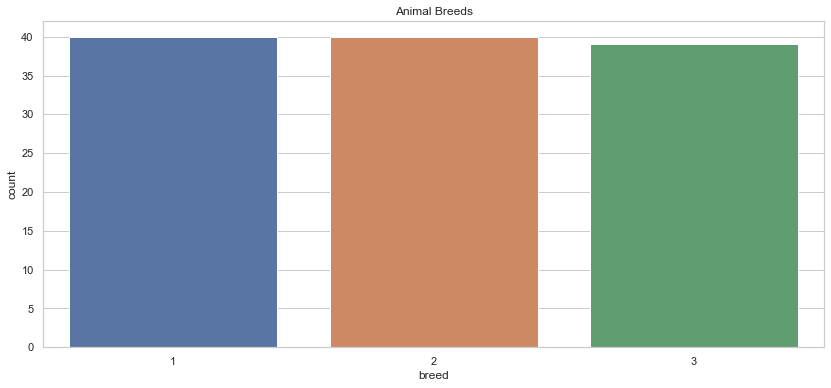

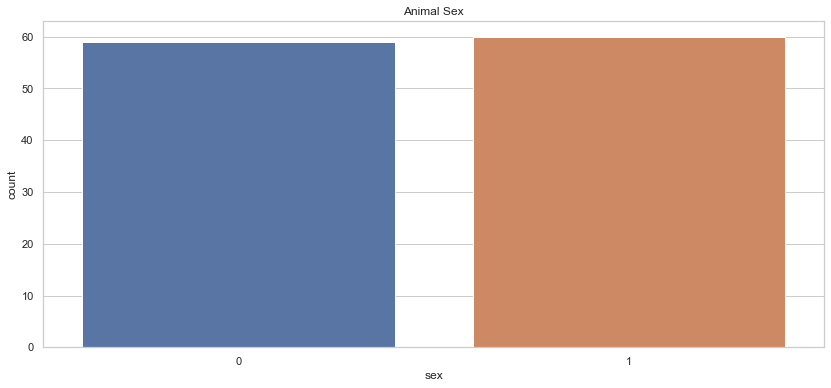

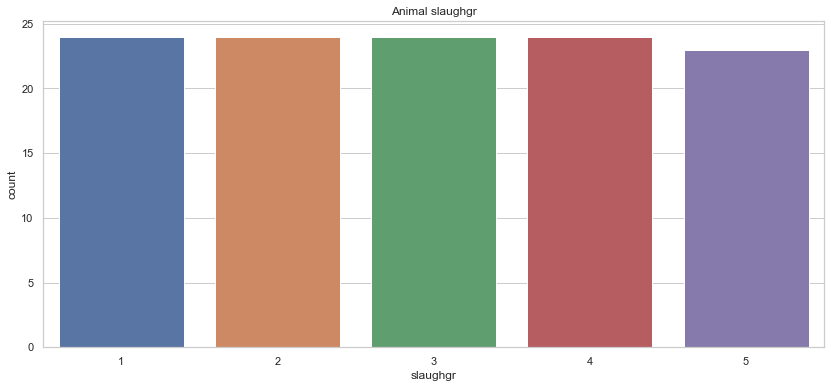

In [4]:
plt.figure(figsize=(14,6))
plt.title('Animal Breeds')
sns.countplot(x='breed', data=data)

plt.figure(figsize=(14,6))
plt.title('Animal Sex')
sns.countplot(x='sex', data=data)

plt.figure(figsize=(14,6))
plt.title('Animal slaughgr')
sns.countplot(x='slaughgr', data=data)

Όπως βλέπουμε παραπάνω, και για τα τρία κατηγορικά χαρακτηριστικά τα δεδομένα είνια κατανεμημένα ομοιόμορφα πράγμα που
σημαίνει ότι δεν υπάρχει μεροληψία ως προς κάποιο συγκεκριμένο χαρακτηριστικό.

## Examine Parts Variance
Θα χρησιοποιήσουμε boxplots για να διαπιστώσουμε τη διακύμανση που παρατηρείται στα βάρη
κάθε τμήματος του ζώου.

<AxesSubplot:>

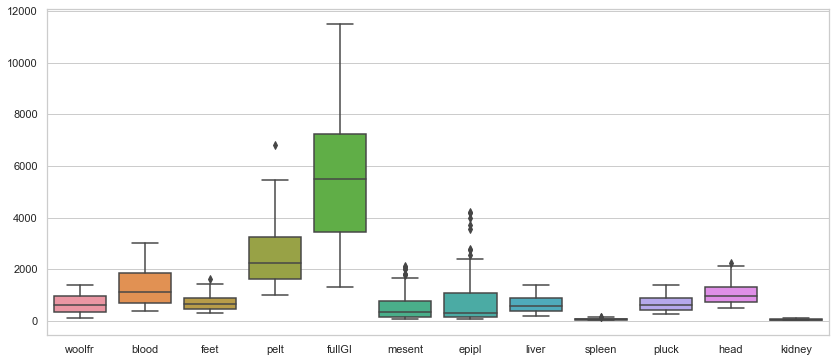

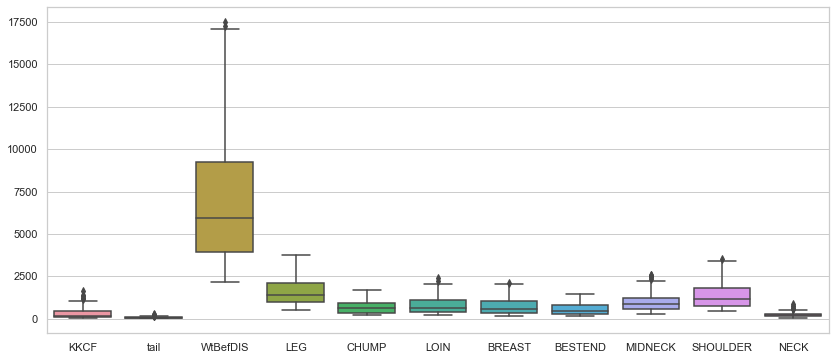

In [5]:
plt.figure(figsize=(14,6))
parts = data[['woolfr','blood','feet','pelt','fullGI','mesent','epipl',
              'liver','spleen', 'pluck', 'head','kidney']]
sns.boxplot(data=parts)

plt.figure(figsize=(14,6))
parts = data[['KKCF', 'tail', 'WtBefDIS', 'LEG', 'CHUMP', 'LOIN',
              'BREAST', 'BESTEND', 'MIDNECK', 'SHOULDER', 'NECK']]
sns.boxplot(data=parts)

Απο τα baxplots παρατηρούμε ότι δεν παρατηρείται ιδιαίτερα μεγάλη διακύμανση στο βάρος των περισσότερων τμημάτων ζώων.
Τη μεγαλύτερη διακύμανση τη παρουσιάζουν τα ακόλουθα χαρακτηριστικά:"blood", "pelt", "fullGI" (?) και "WtfBefDIS" (?).
Επίσης, στο χαρακτηριστικό "epipl" κάποιες τιμές ξεφεύγουν και ίσως είναι outliers.

## Feature Correlation
Αρχικά θα διερευνήσουμε το βαθμό συσχέτισης μεταξύ όλων των χαρακτηριστικών.

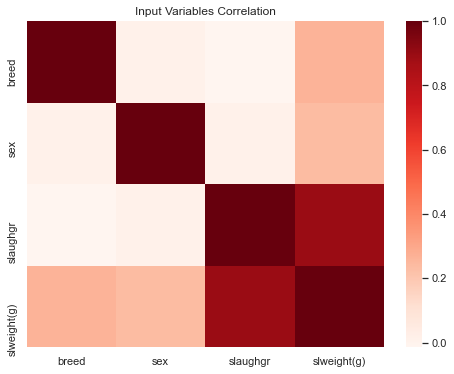

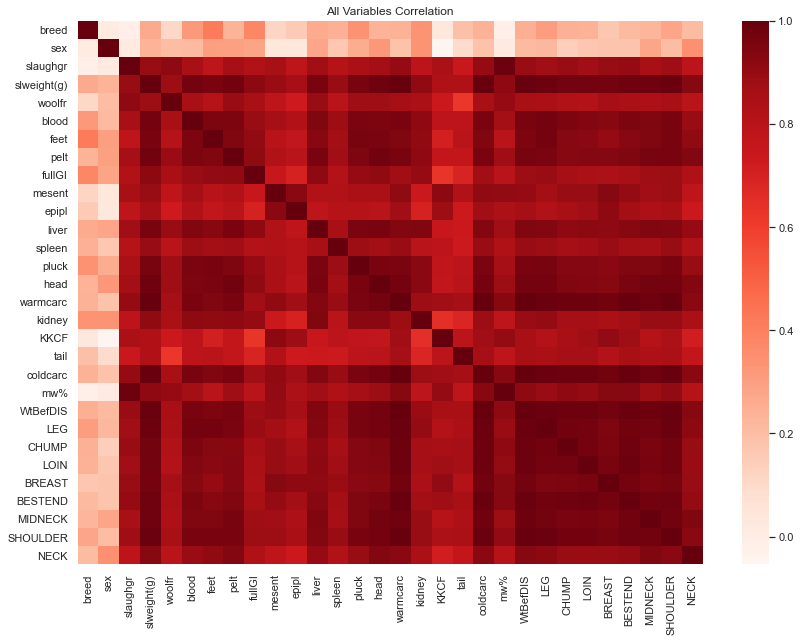

In [6]:
plt.figure(figsize=(8,6))
plt.title('Input Variables Correlation')
input_cols_corr = X.corr()
sns.heatmap(input_cols_corr, annot=False, cmap='Reds')
plt.show()

plt.figure(figsize=(14,10))
plt.title('All Variables Correlation')
output_cols_corr = data.corr()
sns.heatmap(output_cols_corr, annot=False, cmap='Reds')# sns.set(font_scale=0.5)
plt.show()


Παρά το γεγονός ότι τα δεδομένα είναι πάρα πολλά για να είμαστε σε θέση να κατανοήσουμε το heatmap λεπτομερώς μπορούμε
εξάγουμε μερικά συμπεράσματα απο τη γενική εικόνα τους.

Πιό συγκεκριμένα, στο 1ο heatmap βλέπουμε μια αναπαράσταση του βαθμού συσχέτισης μεταξύ των μεταβλητλών εισόδου. Απο την
αναπαράσταση αυτή είναι εμφανές ότι τα χαρακτηριστιά εισόδου είναι αρκετά ασυσχέτιστα μεταξύ τους με εξάιρεση
τα χαρ/κα "slweight(g)" και "slaughgr" τα οπόια παρουσιάζουν υψηλή συσχέτιση. Αυτό σημαίνει ότι τα χρακτητιστικά εισόδου
είναι αρκετά ανεξάρτητα ώστε η χρήση τους ενδεχομένως να προσφέρει αρκετή πληροφορία.

Στό 2ο  heatmap είναι εμφανές πως τα δεδομένα εξόδου έχουν υψηλή συσχέτιση μεταξύ τους αλλά καί με τα δεδομένα εισόδου καθώς
το μεγαλύτερο μέςρος του heatmap είναι βαθιά κοκκινισμένο. Επίσης επαληθέυεται αυτό που παρατηρήσαμε στο 1ο heatmap, δηλαδή
ότι οι συσχετίσεις μεταξύ των μεταβλητών εισόδου είναι χαμηλές σε σχέση με τις συσχετίσεις μεταξύ των δεδομένων εξόδου.

## Feature Importance
Θα κάνουμε μια ανάλυση της σημασίας των χαρακτηριστικών εισόδων στις εξόδους χρησιμοποιώντας τους συντελεστές που
προκύπτουν απο την εκπαίδευση μοντέλων παλλινδρόμησης όπως οι αλγόριθμος XGBoost και Linear Regression.
### XGBoost

In [7]:
# Split train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=96)

XGBoost
R2 score: 0.89719535752799
RMSE: 210.38222665792196


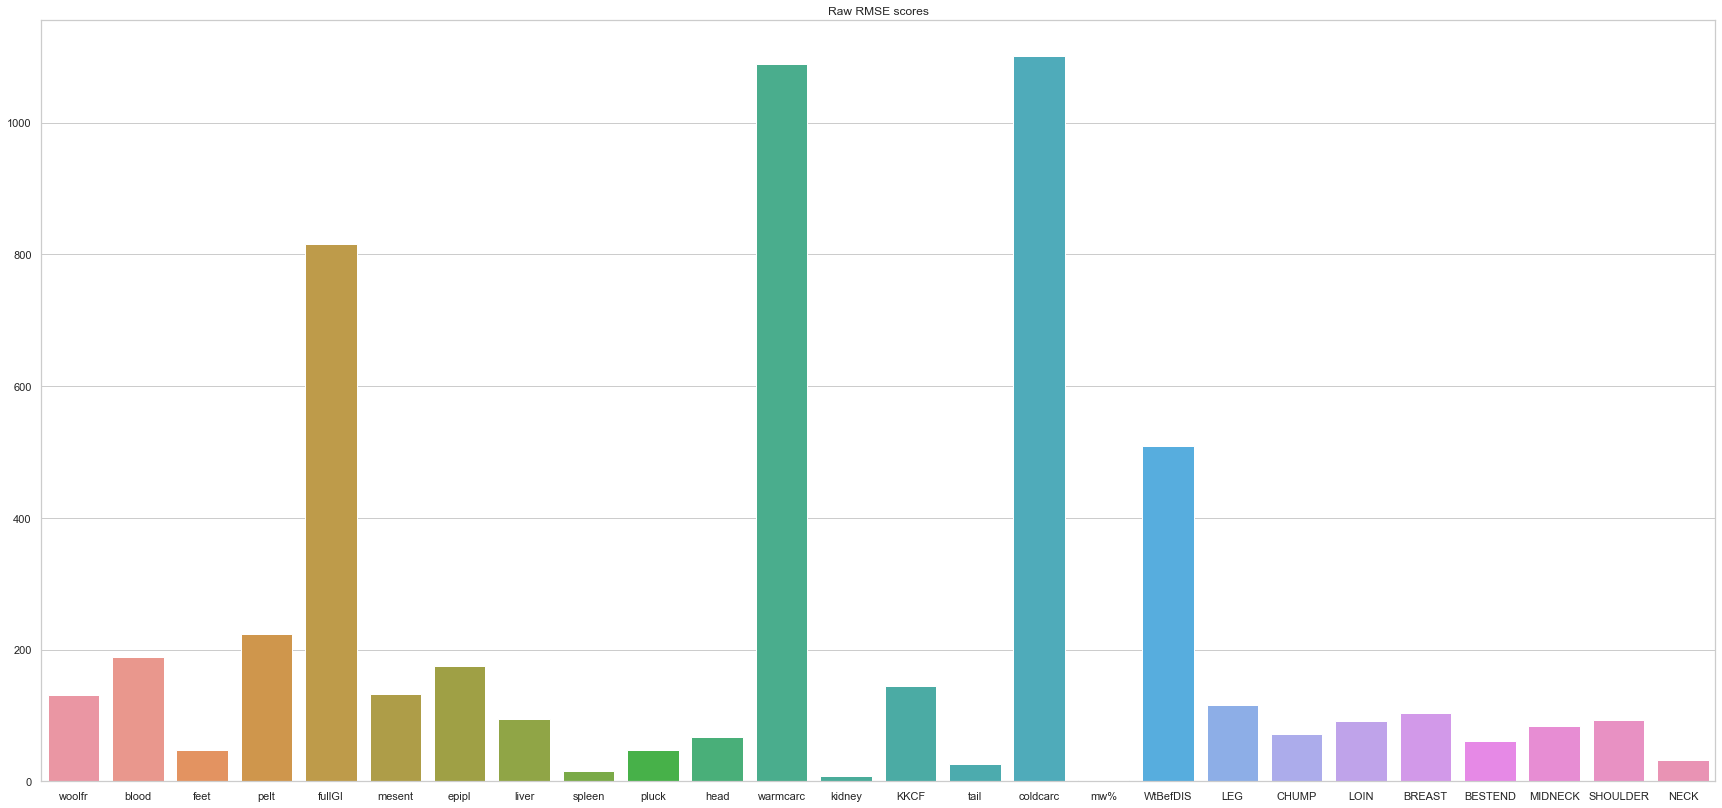

In [8]:
# Run xgboost model & get results
res = run_xgb_model(X_train, X_test, y_train, y_test)
# Print model scores (uniform average)
print(res['model'])
print('R2 score:', res['scores']['ua_score_r2'])
print('RMSE:', res['scores']['ua_score_rmse'])
# Present raw rmse scores with a barplot
scores_barplot(res['scores']['rv_scores_rmse'], y.columns, title='Raw RMSE scores')


Οι μεταβλητές "fullGI", "warmcarc", "coldcarc", "WtBefDIS" έχουν αρκετά μεγάλο σφάλμα (rmse) κατά την πρόβλεψη σε σχέση
με τις υπόλοιπες. Το μέσο ομοιόμορφο RMSE σφάλμα είναι 210.38.


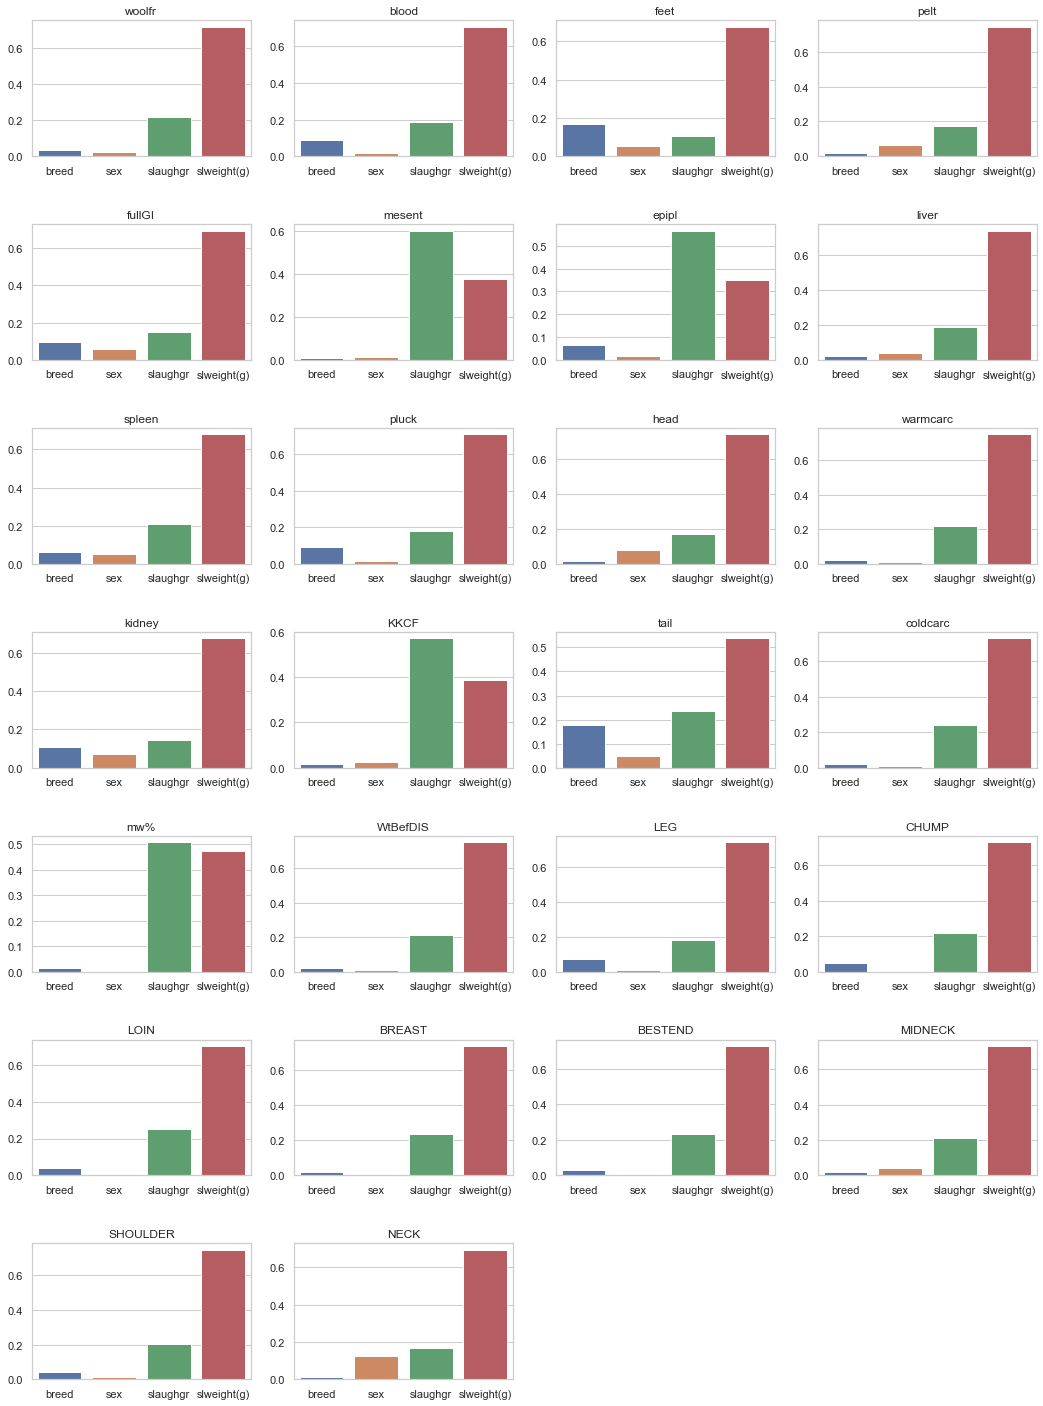

In [9]:
# Plot feature importances barplot for each target variable
plot_feature_imps(res['feat_imps'], X.columns, y.columns)

Είναι ξεκάθαρο ότι το πιό σημαντικό χαρακτηριστικό είναι το slweight(g), ενώ το breed και το sex επηρεάζουν πολύ λίγο
τη πρόβλεψη των μεταβλητών στόχων. Το slaughgr επίσης επηρεάζει αρκετά τις περισσότερες μεταβλητές στόχους.


### Linear Regression

Linear Regression
R2 score: 0.8723149739436958
RMSE: 224.3894285471359


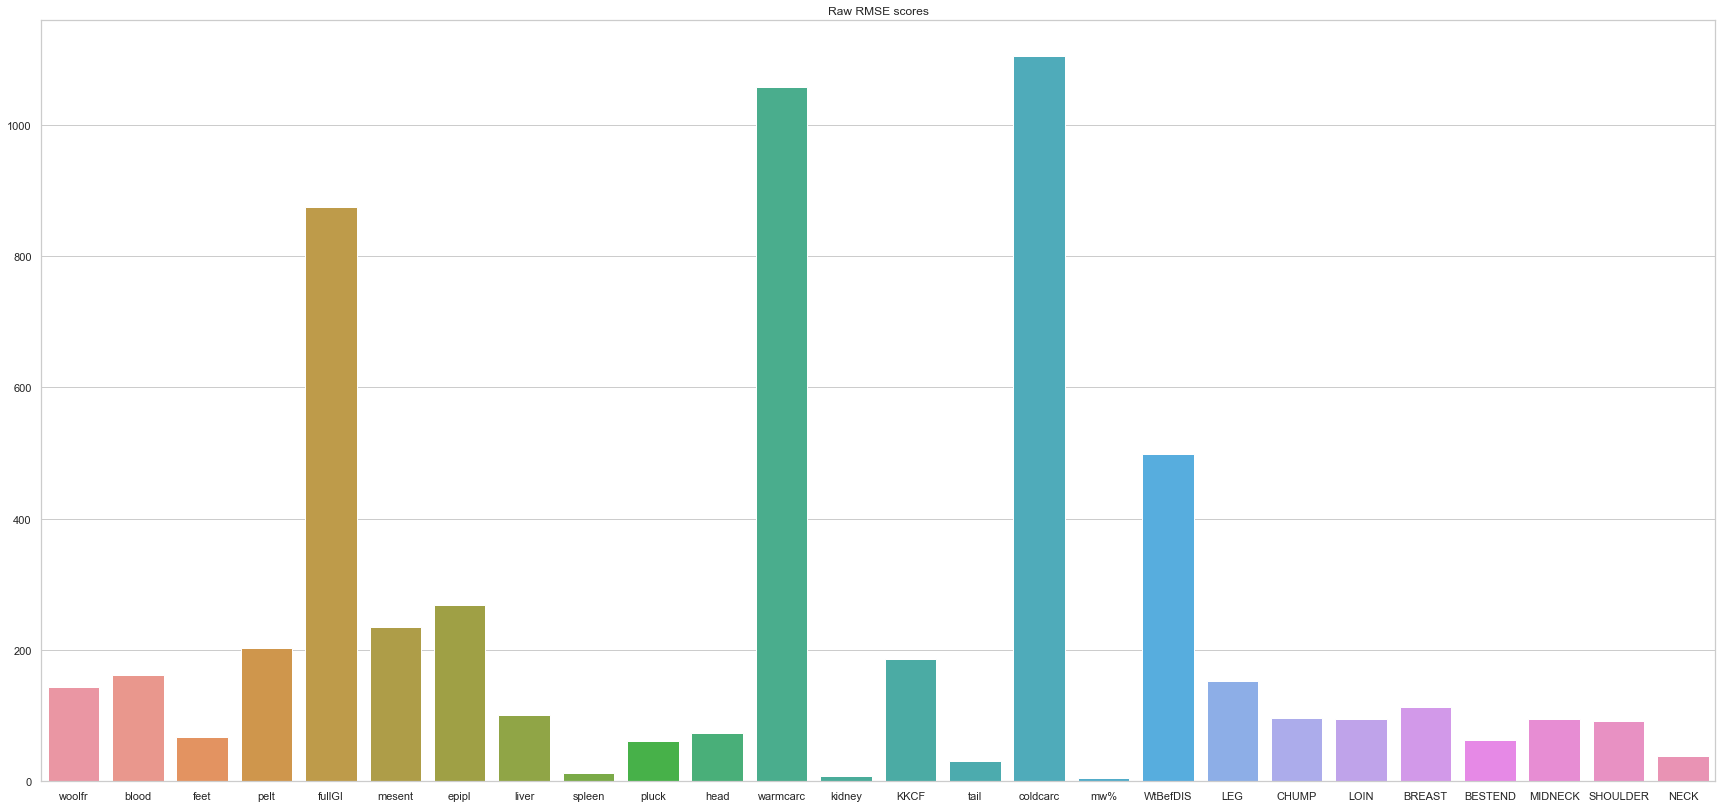

In [10]:
# Run Linear Regression model & get results
res = run_lin_reg_model(X_train, X_test, y_train, y_test)

print(res['model'])
print('R2 score:', res['scores']['ua_score_r2'])
print('RMSE:', res['scores']['ua_score_rmse'])

# Plot individual RMSE scores
scores_barplot(res['scores']['rv_scores_rmse'], y.columns, title='Raw RMSE scores')

Το μοντέλο Linear Regression επιτυγχάνει παρόμοια αποτελέσματα με το XGBoost με λίγο υψηλότερο RMSE περίπου στα 224.38.

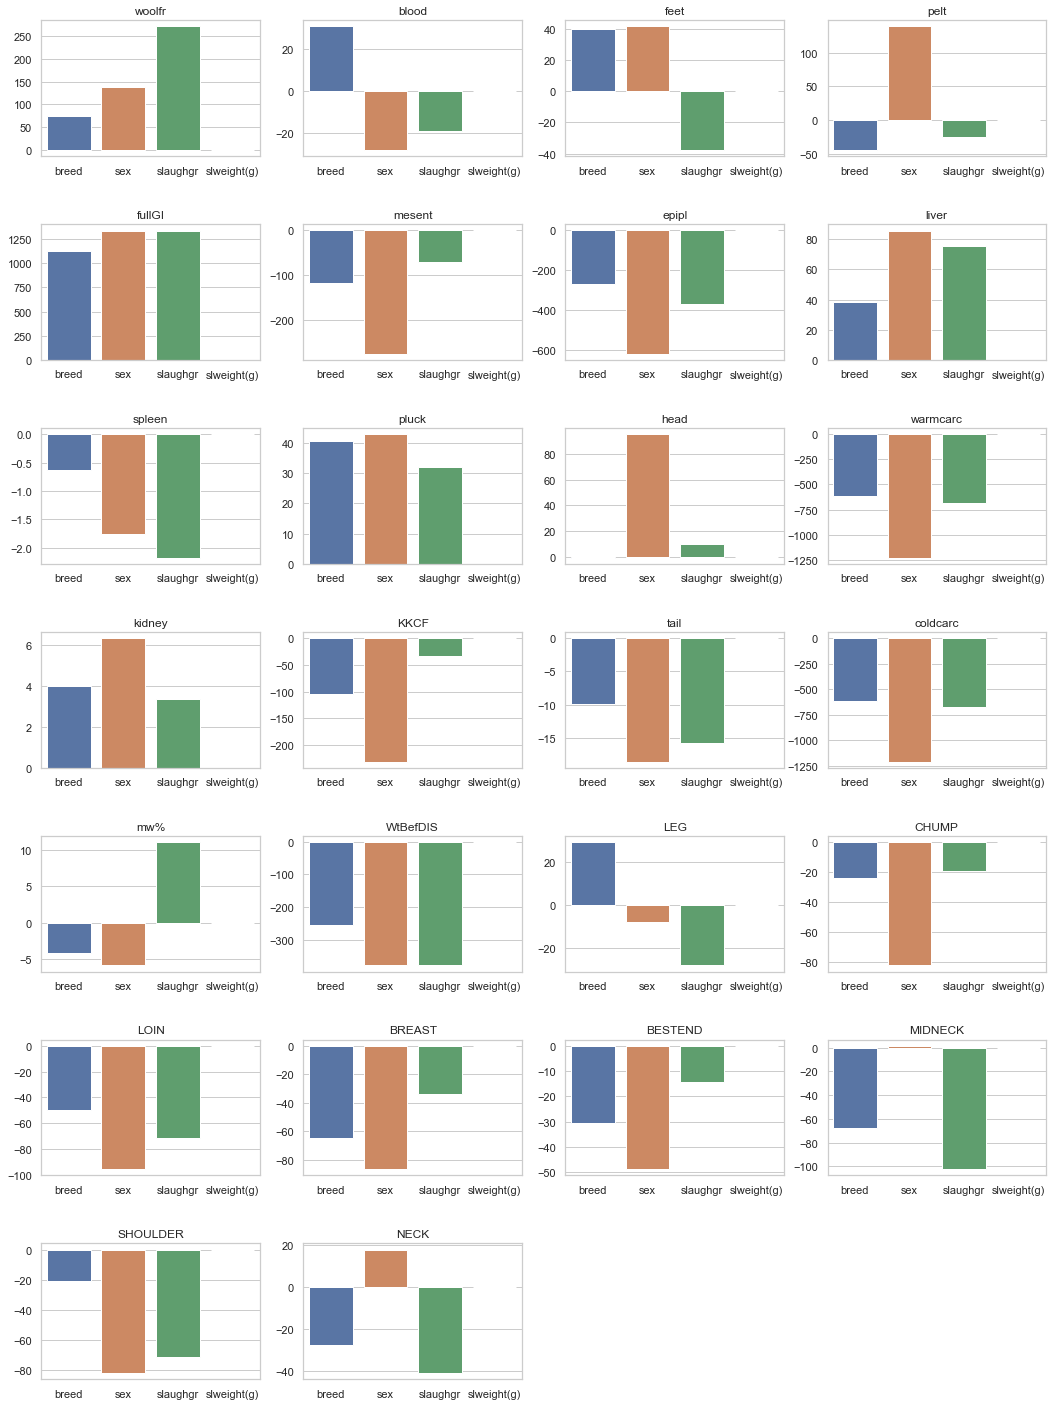

In [11]:
# Plot coefficients
plot_feature_imps(res['feat_imps'], X.columns, y.columns)

Όπως βλέπουμε στα παραπάνω barplots, δεν μπορούμε να βγάλουμε και πολλά συμπαιράσματα απο τους συντελεστές που έχει
αναθέσει ο Linear Regression στις  μεταβλητές για το feature importance των μεταβλητών.
Παρακάτω θα δοκιμάσουμε να κάνουμε scale στα δεδομένα προτού τρέξουμε τον Linear Regression προκειμένου να εξάγουμε μια
καλύτερη αναπαράσταση.

### Linear Regression with Scaling

Κάνουμε scale τα δεδομένα χρησιμοποιώντας τον Standard scaler του sklearn και τρέχουμε
ξανά το Linear Regression μοντέλο.

In [12]:
# Scale data for linear regression
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)
y_scaled = std_scaler.fit_transform(y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = \
    train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=96)


Linear Regression
R2 score: 0.8723149739436591
RMSE: 0.2630212314713398


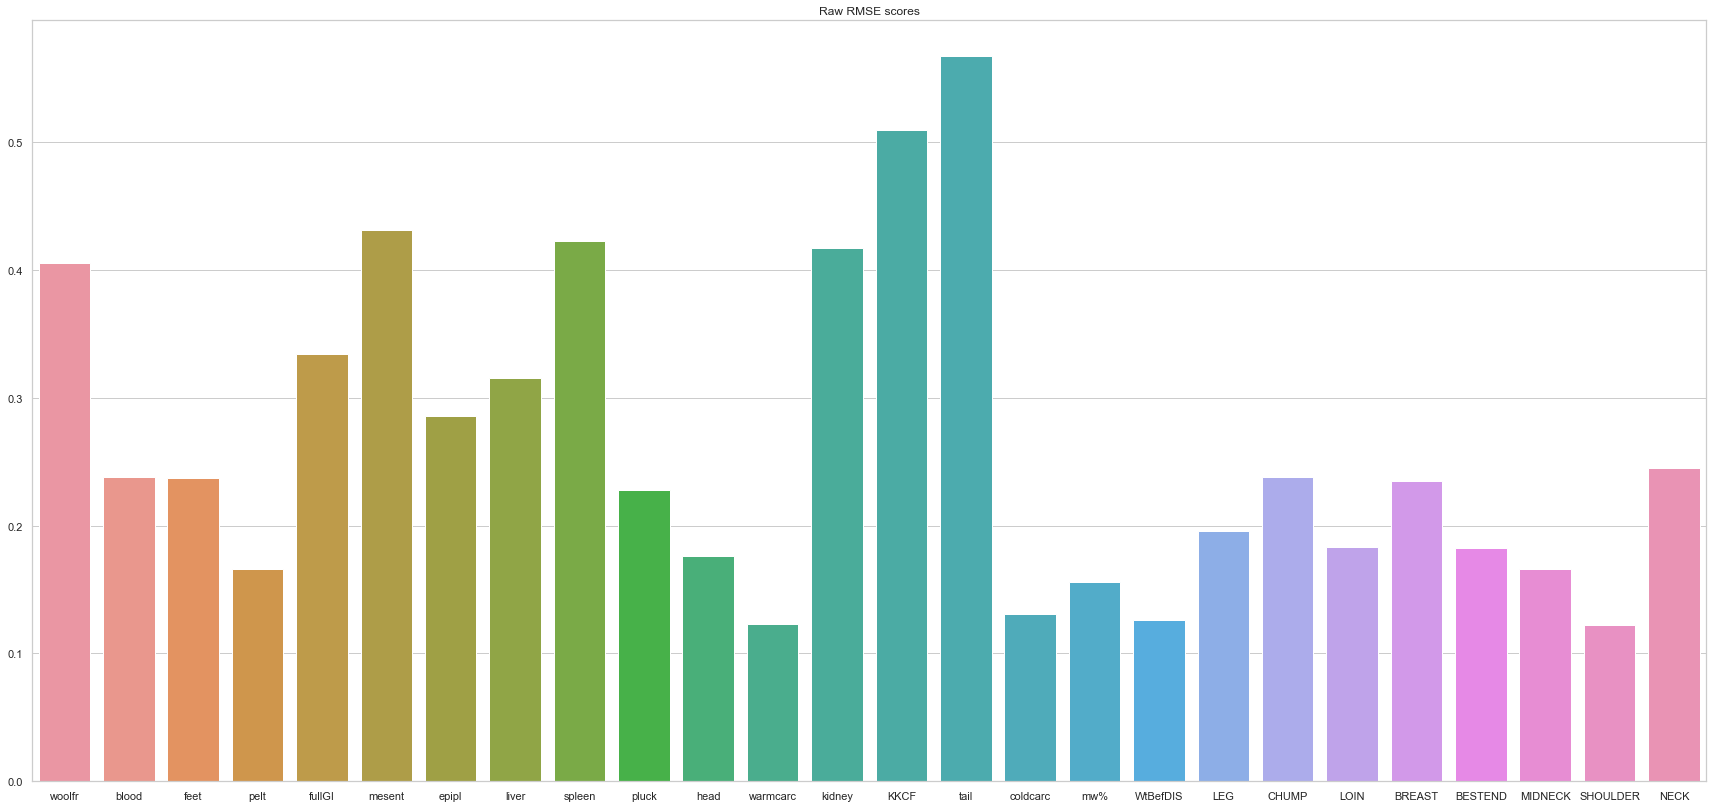

In [13]:
# Rerun Linear regression model on scaled data
res = run_lin_reg_model(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)
print(res['model'])
print('R2 score:', res['scores']['ua_score_r2'])
print('RMSE:', res['scores']['ua_score_rmse'])
# Plot individual RMSE scores
scores_barplot(res['scores']['rv_scores_rmse'], y.columns, title='Raw RMSE scores')

Με το scaling ο Linear regression επιτυγχάνει ακτιβώς το ίδιο R2 score συγκριτκά με την εκτέλεση σε unscaled δεδομένα.

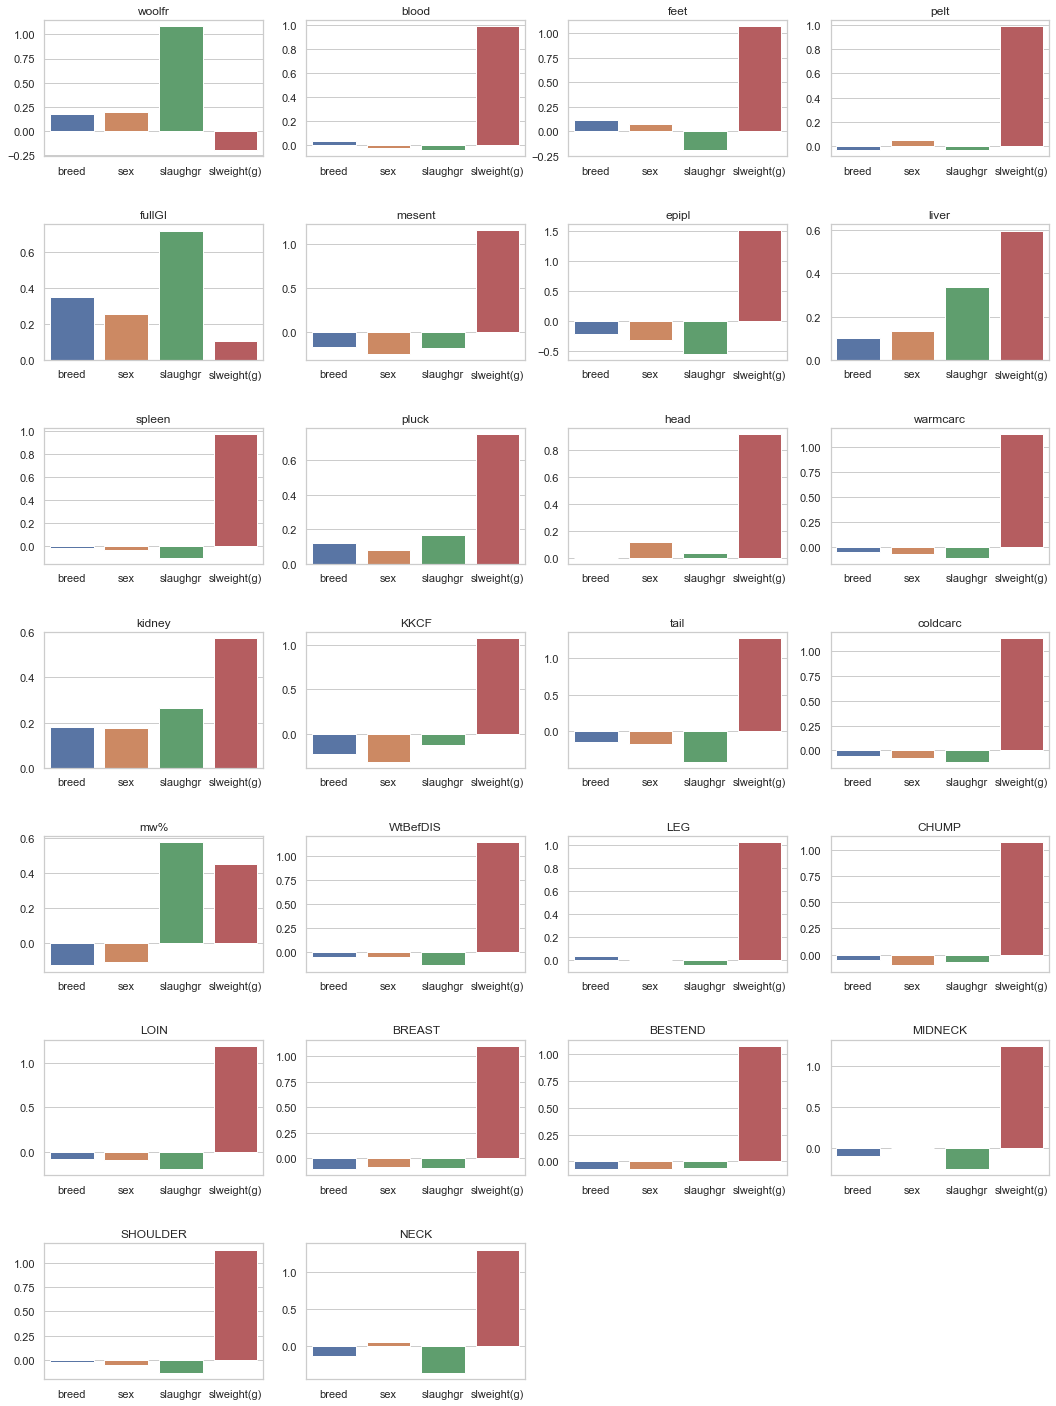

In [14]:
# Plot coefficients
plot_feature_imps(res['feat_imps'], X.columns, y.columns)

Παρατηρώντας τα barplots για κάθε μεταβλητή στόχο, βλέπουμε ότι και πάλι στις περισσότερες περιπτώσεις η μεταβλητή
"slweight(gr)" έχει το μεγαλύτερο importance για τη πρόβλεψη.
Οι αρνητικές τιμές των συντελεστών που παρατηρούνται σε κάποιες περιπτώσεις υποδηλώνουν αρνητική συσχέτιση.
Επίσης, αξίζει να σημειωθεί ότι οι μεταβλητές "slweight(gr)" και "slaughgr" έχουν πολύ υψηλή συσχέτιση όπως συζητήσαμε
παραπάνω (Multicolinearity). Απο αυό το φαινόμενο μπορεί να επηρεαστεί ο linear regression ενώ τα δενδρικά μοντέλα
όπως ο XGBoost δεν επηρεάζονται.

### Drop breed & sex Input Variables

XGBoost
R2 score: 0.8237145659535857
RMSE: 276.46244629102426


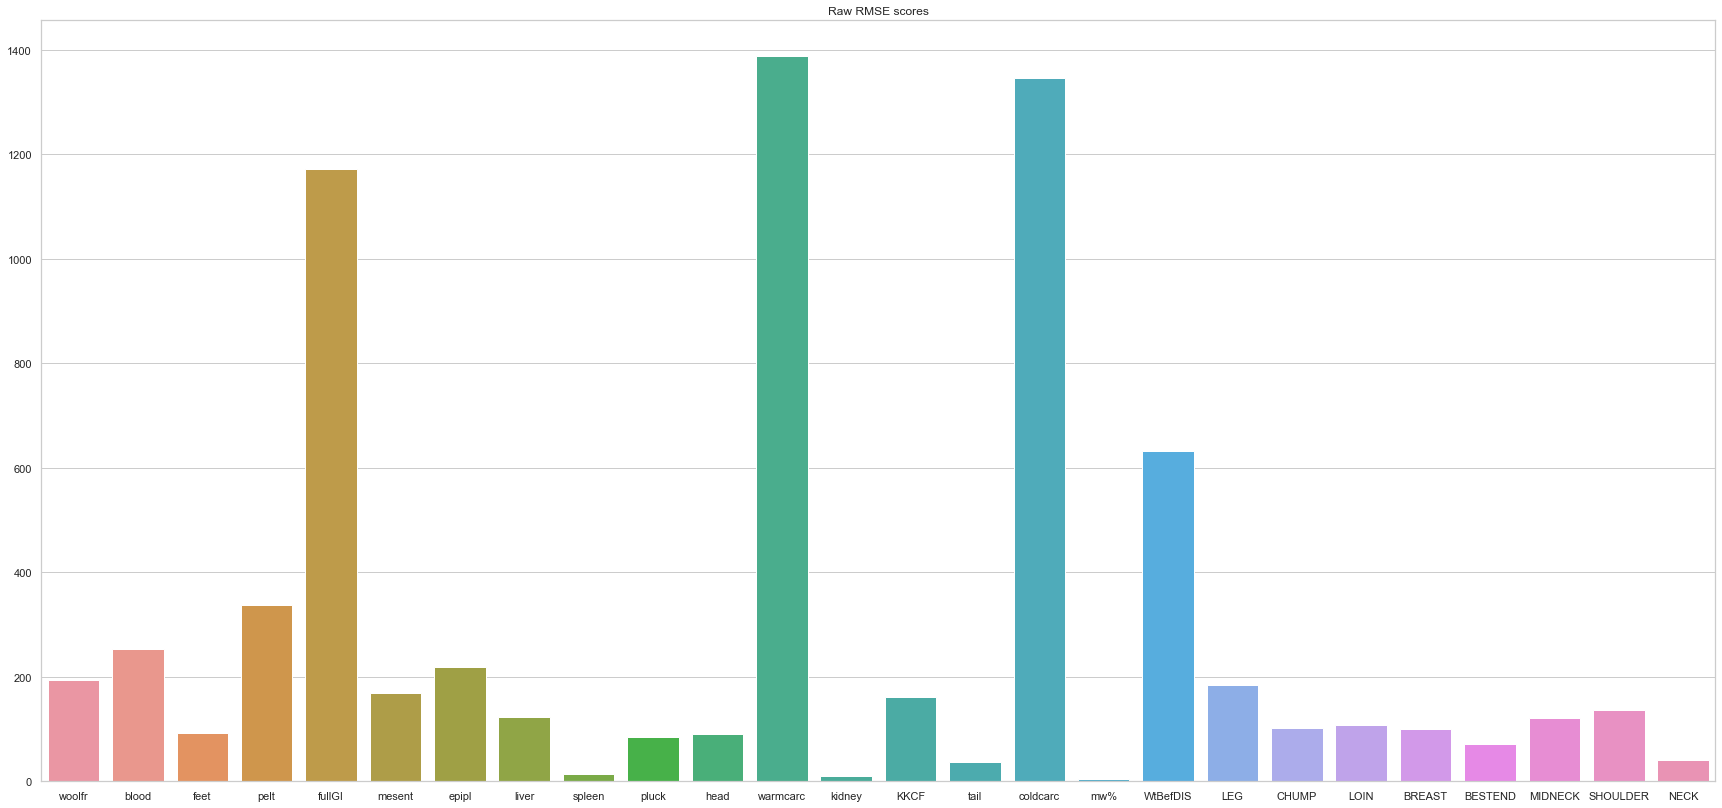

In [15]:
X1 = X.drop(['breed', 'sex'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=96)

# Run xgboost model & get results
res = run_xgb_model(X_train, X_test, y_train, y_test)
# Print model scores (uniform average)
print(res['model'])
print('R2 score:', res['scores']['ua_score_r2'])
print('RMSE:', res['scores']['ua_score_rmse'])
# Present raw rmse scores with a barplot
scores_barplot(res['scores']['rv_scores_rmse'], y.columns, title='Raw RMSE scores')
